# Developing Explanatory Diagrams

### Want a set of plots to use for paper(s) & presentation(s) to illustrate various aspects of the transformations and approximations used in the heliocentric transformation and clustering technique

2 December 2017

This Notebook (HelioClustering_MJP) is a copy/form of the notebook "ITF_mjh"
> "ITF_mjh" contains most of the original development work on the transformations and clustering
> "HelioClustering_MJP" will just grab the initial transformation sections of that code, and reuse it

    * It would be nice to make library routines for the common code in "ITF_mjh" and "HelioClustering_MJP", but I'm probably not going to have time to do a thorough job, so there'll just have to be code duplication
    * I'm going to delete out most of the stuff about reading ITF/UnnumObs
    * I'm going to create sets of very detailed fake tracklets for some sample objects (NEO/MBA/Trojan/...)
    * For the selection of example objects, I'm going to lean on the work I did in mpcpp.FetchJPL
    * For the creation of the tracklets I am going to lean on the work I did in mpcpp.????

# Rough outline of necessary steps 
## Payne, Dec 2nd
 - Define some objects of interest
 - Define time baseline we wish to obtain observations for
 - Convert / obtain topocentric observational equivalents for the above objects at the above times
 - Work towards making a dictionary of arrays for each object
 - For each object we want to have arrays (i.e. as a function of time) for ...
 > heliocentric posns (actual)
 
 > geocentric posns   (actual)
 
 > observer-centric posns (actual)
 
 > helio-centric posn of Earth (actual)
 
 > helio-centric posn of Observer (actual) 
 
 > A variety of transformed quantities using assumed values of \gamma, \dot{\gamma}, etc, etc
 
 - Some additional/overlapping points from High-Rise discussion Dec 4th 2017, 
 > Prob need full state (i.e. vel as well as posn.)
 
 > Will be able to add errors to observed RA/DEC and then propagate this through the analysis to understand the impacts (i.e.e to demonstrate that it agrees with expectations from analytics) 
 
 > At some point it seems likely that I'll want to restrict my sample to observations near opposition

### The kepcart library

You will need to make sure you have a copy of the kepcart library.  There is a copy of it on the MPC bitbucket site, with some instructions.

In [1]:
%matplotlib inline
import numpy as np
import scipy.interpolate
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import math
#import kepcart as kc
import healpy as hp
import collections
import astropy
from collections import defaultdict
from collections import Counter
import MPC_library
import scipy.spatial
import os
import pickle 
import healpy as hp
import brewer2mpl

/Users/matthewjohnpayne/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/matthewjohnpayne/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
brewer2mpl.print_maps('Sequential')
bmap = brewer2mpl.get_map('Paired', 'Qualitative', 5, reverse=True)


Sequential
Blues     :  {3, 4, 5, 6, 7, 8, 9}
BuGn      :  {3, 4, 5, 6, 7, 8, 9}
BuPu      :  {3, 4, 5, 6, 7, 8, 9}
GnBu      :  {3, 4, 5, 6, 7, 8, 9}
Greens    :  {3, 4, 5, 6, 7, 8, 9}
Greys     :  {3, 4, 5, 6, 7, 8, 9}
OrRd      :  {3, 4, 5, 6, 7, 8, 9}
Oranges   :  {3, 4, 5, 6, 7, 8, 9}
PuBu      :  {3, 4, 5, 6, 7, 8, 9}
PuBuGn    :  {3, 4, 5, 6, 7, 8, 9}
PuRd      :  {3, 4, 5, 6, 7, 8, 9}
Purples   :  {3, 4, 5, 6, 7, 8, 9}
RdPu      :  {3, 4, 5, 6, 7, 8, 9}
Reds      :  {3, 4, 5, 6, 7, 8, 9}
YlGn      :  {3, 4, 5, 6, 7, 8, 9}
YlGnBu    :  {3, 4, 5, 6, 7, 8, 9}
YlOrBr    :  {3, 4, 5, 6, 7, 8, 9}
YlOrRd    :  {3, 4, 5, 6, 7, 8, 9}


## Need to be able to handle observatory codes

In [3]:
Observatories = MPC_library.Observatories

ObservatoryXYZ = Observatories.ObservatoryXYZ

Observatories.getObservatoryPosition('F51', 2457000.5)



array([0.22807555, 0.87911034, 0.38114111])

# MPCPP
## Doing imports & test-prints to see the standard list of objects I created
> Note that on laptop I had to do some yak-shaving to get mpcpp to import
>> conda update conda

>> conda update python

>> conda update numpy

> Then could go to the mpcpp README instructions to do the mpcpp install commands

>> https://bitbucket.org/mpcdev/mpcpp/src

In [4]:
import mpcpp ; import mpcpp.fetcher ; from mpcpp.fetcher import fetcherJPL as FetchJ
# Just hacking a basic call so that I can get the standard list of sample names
Name    = 'Eros' ; Epoch   = 2457446.177083 ; ObsCode = 568
qry1 = FetchJ.JPLQ({'body':Name , 't':Epoch, 'OC': ObsCode})
# Define the sample I'll use: the first one in each category ... 
sample__ = {k:v[0] for k,v in qry1.sample_names().items() if '1995 O1' not in v[0] and '2001QR322' not in v[0]}
print (sample__ )


{'MBA': 'Crocco', 'CEN': 'Chiron', 'TNO': 'Sedna', 'HIL': 'Hilda', 'BIG': 'Ceres', 'HUN': 'Hungaria', 'JT': 'Achilles', 'NEO': 'Alinda'}


# In a few cells time, we will use spicepy
- There MUST be an automated way to map NAME:JPL_ID (it seems to be needed at some point in the proceedings)
- But in case I can't find the method, here is a by-hand mapping ...

In [5]:
sampleIDs__ = {
        'Chiron':'2002060', 
        #'C/1995 O1':'1000132', 
        #'2001QR322':'3092453', 
        'Hungaria': '2000434', 
        'Alinda':'2000887', 
        'Achilles':'2000588', 
        'Ceres':'2000001', 
        'Crocco':'2010606', 
        'Sedna':'2090377', 
        'Hilda':'2000153'}

# Top level definitions 
 - These settings & quantities are general across all objects, so I'm just putting them into a sort of global set of definitions
 - Quantities defined here are:
 > Evaluation Times
 
 > Observatory Code(s) 

In [6]:

#
# TIMES (UTC or TDB ?)  
# -  I'm going to do this so that I have one hour long tracklet per day, every day, for a year
#
t0 = 2458088.5      ## Dec 1st 2017
t1 = 2458088.541667 ## t0 + 1hr 
n_days = 365
t_ = [t0 + i for i in range(n_days)]
t_.extend([t1 + i for i in range(n_days)])
t_.sort()
tJD_ = ['%f JD' % t for t in t_ ] ###<<<--- # UTC or TDB : Need to read https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/FORTRAN/req/time.html#STR2ET
print("\n TIMES ... ")
print(len(t_), t_[:10], tJD_[:10])




#
#     heliocentric position of the Earth/observatory in equatorial cartesian coordinates.
#
Earth_  = np.array([Observatories.getObservatoryPosition('500', t) for t in t_])
F51_   = np.array([Observatories.getObservatoryPosition('F51', t) for t in t_])

#print("\n POSITIONS ... ")
#plt.title("POSITIONS")
#plt.plot(F51_[:,0], F51_[:,1],'.')   
#plt.plot(F51_[:,0]-Earth_[:,0], F51_[:,1]-Earth_[:,1],'.')
#plt.plot(F51_[:,0]-Earth_[:,0],'.')
#plt.plot(F51_[:,0]-Earth_[:,0], F51_[:,2]-Earth_[:,2],'.')
#plt.plot(F51_[:,2]-Earth_[:,2],'.')



#
#    # This rotation is taking things from equatorial to ecliptic
#
rot_mat = MPC_library.rotate_matrix(-MPC_library.Constants.ecl)
def equatorial_to_ecliptic(v, rot_mat=MPC_library.rotate_matrix(-MPC_library.Constants.ecl)):
    return np.dot(rot_mat, v.reshape(-1, 1)).flatten()


#
#     So now we can get the heliocentric ecliptic coordinates of the Earth/observatory 
#
HEC_Earth_ = np.array( [equatorial_to_ecliptic(posn) for posn in Earth_ ] )
HEC_F51_   = np.array( [equatorial_to_ecliptic(posn) for posn in F51_ ] )  

        
print("\n POSITIONS ... ")
for t, E, HEC in zip(t_[:2], Earth_[:2], HEC_Earth_[:2]):
    print(t, E, HEC)


 TIMES ... 
730 [2458088.5, 2458088.541667, 2458089.5, 2458089.541667, 2458090.5, 2458090.541667, 2458091.5, 2458091.541667, 2458092.5, 2458092.541667] ['2458088.500000 JD', '2458088.541667 JD', '2458089.500000 JD', '2458089.541667 JD', '2458090.500000 JD', '2458090.541667 JD', '2458091.500000 JD', '2458091.541667 JD', '2458092.500000 JD', '2458092.541667 JD']

 POSITIONS ... 
2458088.5 [0.35761336 0.84313266 0.36550175] [ 3.57613355e-01  9.18947336e-01 -3.74501232e-05]
2458088.541667 [0.35693373 0.84336829 0.36560391] [ 3.56933729e-01  9.19204158e-01 -3.74524011e-05]


# Instantiate a dictionary to temporarily hold various pieces of raw data


In [7]:
# Instantiate a dictionary to temporarily hold various pieces of raw data
rawdataDict__ = {}

rawdataDict__['t_']=t_
rawdataDict__['tJD_']=tJD_

rawdataDict__['Earth_'] = Earth_
rawdataDict__['F51_'] = F51_
rawdataDict__['HEC_Earth_'] = HEC_Earth_
rawdataDict__['HEC_F51_'] = HEC_F51_



# Let's do a test query for Ceres (using SPICE within MPCPP)

# Now let's download the posn & vel data for a everything that's in the sample__ dictionary
 - About 8 different obects at this point 

In [8]:
# Making dictionaries within dictionaries ...
rawdataDict__['helio_posnEQ'] = {} 
rawdataDict__['helio_velEQ']  = {} 

In [9]:
# Enable spicey shit
import spiceypy
import mpcpp.spice 
from mpcpp.spice import spice as spice
# Load the standard kernals, including the lead-second one
a = spice.KernelDownloads( {} ) 
a.startup_kernels()
spiceypy.furnsh(a.meta_filestem)

making mass file :  /Users/matthewjohnpayne/mpcpp_data/spice_data/gm_MJP.tpc


In [10]:
def pv_from_state(state_):
    """ Convenience function to split and convert returned 6-component states 
    """
    # split 
    posns=np.array([ item[0:3] for item in state])
    vels=np.array([ item[3:6] for item in state])
    # convert 
    posns = np.array([spiceypy.convrt(p , 'km', 'au') for p in posns.flatten()]).reshape((-1,3))
    vels = np.array([spiceypy.convrt(v , 'km', 'au')*24.*3600. for v in vels.flatten()]).reshape((-1,3))
    # return separate arrays
    return posns, vels
    


for popn,NAME in sample__.items(): 
    a = spice.KernelDownloads( {} )   ## <<-- {} because wants input params
    a.get_kernel(NAME)
    print("\n", NAME, sampleIDs__[NAME])
    spiceypy.furnsh(os.path.join(a.data_dir, a.gotKernel + ".bsp"))        
    spiceypy.furnsh(os.path.join(a.data_dir, 'naif0012.tls'))        

    
    # This is the basic call that gets posn only 
    posns, lTTs = spiceypy.spkpos(sampleIDs__[NAME], spiceypy.str2et(tJD_), 'J2000', 'NONE', '10')
    posns = np.array(posns).flatten()
    helio_tracklet_posns = np.array([spiceypy.convrt(p , 'km', 'au') for p in posns]).reshape((-1,3))
    print("HERE:", posns, helio_tracklet_posns)
    
    # This call should get posn & vel and return as a state ...
    #state, lTTs = spiceypy.spkezr(sampleIDs__[NAME], spiceypy.str2et(tJD_), 'J2000', 'NONE', '10')
    #posns_ , vels_ = pv_from_state(state)
    # Put into the Dictionary of Things 
    
    rawdataDict__['helio_posnEQ'][NAME]= helio_tracklet_posns
    #rawdataDict__['helio_vel'][NAME] = vels_

    print( len(rawdataDict__['helio_posnEQ'][NAME]),rawdataDict__['helio_posnEQ'][NAME][:1])
    #print( len(rawdataDict__['helio_vel'][NAME]), rawdataDict__['helio_vel'][NAME][:1])




/Users/matthewjohnpayne/mpcpp_data/spice_data/smb_spk -b "Crocco;" 1900-Jan-1 2100-JAN-1 mpayne@cfa.harvard.edu /Users/matthewjohnpayne/mpcpp_data/spice_data/Crocco.bsp
self.gotKernel Crocco

 Crocco 2010606
HERE: [ 2.93807710e+08 -2.04176312e+08 -2.28189755e+08 ...  3.99109622e+08
  2.24015393e+08  6.70925817e+07] [[ 1.96398324 -1.36483434 -1.5253543 ]
 [ 1.9642986  -1.36454912 -1.5252199 ]
 [ 1.97153962 -1.3579805  -1.52211915]
 ...
 [ 2.67159132  1.49061897  0.44240665]
 [ 2.66803809  1.49716607  0.44823298]
 [ 2.66788304  1.49745041  0.44848621]]
730 [[ 1.96398324 -1.36483434 -1.5253543 ]]
/Users/matthewjohnpayne/mpcpp_data/spice_data/smb_spk -b "Chiron;" 1900-Jan-1 2100-JAN-1 mpayne@cfa.harvard.edu /Users/matthewjohnpayne/mpcpp_data/spice_data/Chiron.bsp
self.gotKernel Chiron

 Chiron 2002060
HERE: [ 2.77459837e+09 -2.04564433e+08  1.07937941e+08 ...  2.79816614e+09
 -4.20796307e+07  1.60211987e+08] [[18.54704457 -1.36742878  0.72152057]
 [18.54706898 -1.36730486  0.72156083]
 [18

# Make some simple test plots of the coordinates returned above ...
 - Equatorial

/Users/matthewjohnpayne/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


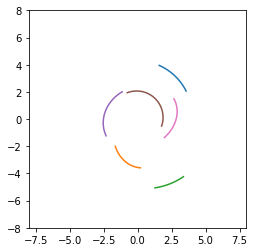

In [11]:
for NAME, data in rawdataDict__['helio_posnEQ'].items() :
    if NAME != 'Sedna': 
        x_ = data[:,0]
        y_ = data[:,1]

        plt.plot(x_,y_)
        mx = 8
        plt.xlim([-mx,mx])
        plt.ylim([-mx,mx])
        plt.axes().set_aspect('equal')#, 'datalim')


# Convert the imported coordinates to ECLIPTIC

In [12]:
rawdataDict__['helio_posn'] = {} 
for popn,NAME in sample__.items(): 
    rawdataDict__['helio_posn'][NAME] = np.array([ equatorial_to_ecliptic(vec) for vec in rawdataDict__['helio_posnEQ'][NAME]])


/Users/matthewjohnpayne/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


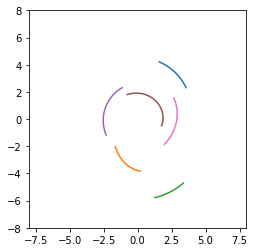

In [13]:
for NAME, data in rawdataDict__['helio_posn'].items() :
    if NAME != 'Sedna': 
        x_ = data[:,0]
        y_ = data[:,1]

        plt.plot(x_,y_)
        mx = 8
        plt.xlim([-mx,mx])
        plt.ylim([-mx,mx])
        plt.axes().set_aspect('equal')#, 'datalim')



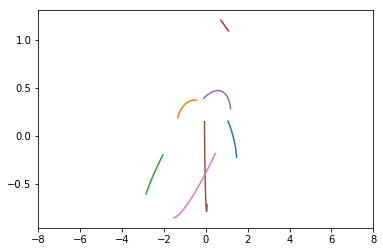

In [14]:
for NAME in rawdataDict__['helio_posnEQ'].keys() :
    EQ = rawdataDict__['helio_posnEQ'][NAME]
    EC = rawdataDict__['helio_posn'][NAME]


    if NAME != 'Sedna': 
 
        plt.plot(EQ[:,2],EC[:,2])
        mx = 8
        plt.xlim([-mx,mx])
        #plt.ylim([-mx,mx])
        #plt.axes().set_aspect('equal')#, 'datalim')



# Now going to experiment with using the "CallHorizons" routine to get the RA/Dec for those objects 
 - I'm probably going to take the opportunity to check those results against explicit transformation
 - Will be of some use for writing tests for MPC code (mpcpp) 

# For some fucking erason th ecallhorizons routine stopped working, so am going to try using the "astroquery" package

In [101]:
# For some fucking erason th ecallhorizons routine stopped working, so am going to try using the "astroquery" package
from astroquery.jplhorizons import Horizons
from astroquery.jplhorizons import conf
conf.horizons_server = 'https://ssd.jpl.nasa.gov/horizons_batch.cgi'

obj = Horizons(id='Eros', location='568',epochs=[2457446.177083,2457447.177083])
eph = obj.ephemerides()
eph
print(list(eph['RA']), type(list(eph['RA'])))

[292.46003, 293.09031] <class 'list'>


# Test call for ERO ...
 ### Here I establish that for some reason "astroquery" craps out for calls longer than ~500 time-samples (same as "callhorizons")

### Here I deal with the above problem by
 - Chopping times into "chunks" 
 - Smushing the data into some dictionary structure to cover the entire set of time-samples

In [102]:
import sys
def chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]
def extract_data_of_interest_from_query(qry):
    return { field : list(qry[field]) for field in qry.columns }#if field in ['RA','DEC']}
def combined_time_chunk_data(queries):
    D__ = {} 
    for qry in queries:
        for field,data in extract_data_of_interest_from_query(qry).items():
            if field in D__:
                D__[field] = np.append(D__[field],data)
            else:
                D__[field] = data
    return D__ 
def query_JDs(Name, chunk , ObsCode):
    obj = Horizons(id=Name, location=ObsCode,epochs=chunk)
    return obj.ephemerides()
    
def query_wrapper(Name, times, ObsCode, step=499):
    # chopping into lengths of 500, as established this worked above ... 
    queries = [ query_JDs(Name, chunk , ObsCode) for chunk in chunks(times,step) ]
    return  combined_time_chunk_data(queries)


    

In [103]:
# Here I am demonstrating that the above fix works
# --- So don't need to continually rerun this  
Name    = 'Ceres'
for j in [400,500,700]:
    temp_t = [2457446.17 + i for i in range(j)] #[2457446.177083,2457447.177083,2457448.177083]
    D__ = query_wrapper(Name, temp_t, ObsCode)
    print(j, len(D__['RA']) )



400 400


/Users/matthewjohnpayne/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:553: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


500 500
700 700


# Let's go ahead and make all of the queries for all of the objects of interest ...


In [105]:
rawdataDict__['GeoObs'] = {} 
rawdataDict__['F51Obs'] = {} 

for popn,NAME in sample__.items(): 
    # We are now make the query
    # Each query returns a dictionary 
    # We then stuff the entire dictionary into the appropriate rawdataDict__ slot ...
    rawdataDict__['GeoObs'][NAME] = query_wrapper(NAME, t_, '500')
    rawdataDict__['F51Obs'][NAME] = query_wrapper(NAME, t_, 'F51')

    print(NAME, " : ", len(rawdataDict__['GeoObs'][NAME].keys()), len(rawdataDict__['GeoObs'][NAME]['RA']))
    
    

/Users/matthewjohnpayne/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:553: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


Crocco  :  36 730
Chiron  :  36 730
Sedna  :  35 730
Hilda  :  36 730
Ceres  :  36 730
Hungaria  :  36 730
Achilles  :  36 730
Alinda  :  36 730


# It'll be useful to do unit vector calculations for those observations
 - Hope the units are correct ... 

In [106]:
rawdataDict__['GeoUV'] = {} 
rawdataDict__['F51UV'] = {} 


In [107]:
# Transform from observational RA/DEc to a Unit Vector towards the observation
def get_unitvec_from_RADEC(RA,DEC):
    raDeg, decDeg = RA,DEC # MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec)
    x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
    y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
    z = np.sin(decDeg*np.pi/180.)
    return np.array( [x,y,z] )
   
# We add the unit vectors into the appropriate dictionary 
for popn,NAME in sample__.items(): 
    rawdataDict__['GeoUV'][NAME] = [ get_unitvec_from_RADEC(RA,DEC) for RA, DEC in zip( rawdataDict__['GeoObs'][NAME]['RA'],rawdataDict__['GeoObs'][NAME]['DEC'])]
    rawdataDict__['F51UV'][NAME] = [ get_unitvec_from_RADEC(RA,DEC) for RA, DEC in zip( rawdataDict__['F51Obs'][NAME]['RA'],rawdataDict__['F51Obs'][NAME]['DEC'])]

    print(NAME)
    print(rawdataDict__['GeoObs'][NAME]['RA'][:2])
    print(rawdataDict__['GeoObs'][NAME]['DEC'][:2])
    print(rawdataDict__['GeoUV'][NAME][:2])




Crocco
[306.03306 306.05055]
[-34.70322 -34.6974 ]
[array([ 0.48360902, -0.66482368, -0.56932573]), array([ 0.48384598, -0.66472278, -0.56924222])]
Chiron
[353.06982 353.06974]
[1.11279 1.11255]
[array([ 0.9925067 , -0.12063699,  0.01942063]), array([ 0.99250662, -0.12063839,  0.01941644])]
Sedna
[56.37924 56.37882]
[7.48284 7.48277]
[array([0.548978  , 0.82562915, 0.13022925]), array([0.54898414, 0.82562526, 0.13022804])]
Hilda
[20.78642 20.78413]
[11.4454  11.44336]
[array([0.91631843, 0.34782822, 0.19843403]), array([0.91633894, 0.3477941 , 0.19839913])]
Ceres
[142.10985 142.11571]
[23.21031 23.21257]
[array([-0.72531617,  0.564443  ,  0.3941073 ]), array([-0.72536162,  0.56435927,  0.39414355])]
Hungaria
[315.92177 315.9451 ]
[-12.39474 -12.3949 ]
[array([ 0.70164641, -0.67942591, -0.21464566]), array([ 0.70192257, -0.67913973, -0.21464839])]
Achilles
[278.79857 278.80721]
[-28.3114  -28.31035]
[array([ 0.13466442, -0.87002284, -0.47426339]), array([ 0.13479694, -0.87001111, -0.474

# Make some trial RA/DEC plots

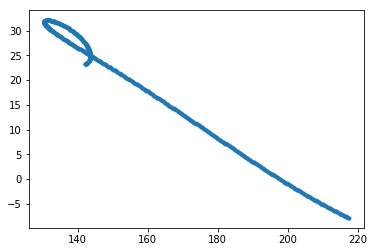

In [108]:
i=000*2;
f=200*2
NAME = 'Ceres'
plt.plot(rawdataDict__['GeoObs'][NAME]['RA'],rawdataDict__['GeoObs'][NAME]['DEC'],'.')   
#plt.plot(rawdataDict__['F51UV'][NAME]['RA'][i:f]-rawdataDict__['F51UV'][NAME]['RA'][i:f],rawdataDict__['F51UV'][NAME]['DEC'][i:f]-rawdataDict__['F51UV'][NAME]['DEC'][i:f],'.')   




# In the above, we have imported RA & DEC (amongst other things)
## But the RA & DEC are (probably) in EQUATORIAL coordinates
## And hence so are the UnitVectors derived from them 
## Let's convert these to ECLIPTIC coordinates

In [109]:
rawdataDict__['TEC_GeoUV'] = {} 
rawdataDict__['TEC_F51UV'] = {} 

In [110]:
for popn,NAME in sample__.items(): 
    rawdataDict__['TEC_GeoUV'][NAME] = [ equatorial_to_ecliptic(vec) for vec in rawdataDict__['GeoUV'][NAME] ]
    rawdataDict__['TEC_F51UV'][NAME] = [ equatorial_to_ecliptic(vec) for vec in rawdataDict__['F51UV'][NAME] ]
 
print(rawdataDict__['GeoUV'][NAME][:2])
print(rawdataDict__['TEC_GeoUV'][NAME][:2])


[array([-0.55976057, -0.79553133, -0.231944  ]), array([-0.55952139, -0.79568026, -0.23201021])]
[array([-0.55976057, -0.82214776,  0.10363959]), array([-0.55952139, -0.82231074,  0.10363808])]


# Let's save all of the imported data into a pickle file so that we can restart from here without having to go through all of the above 

In [111]:
# Not enabled at present so that it doesn't run by accident ...
pickle.dump( rawdataDict__, open( "ExampleObjectPickle.p", "wb" ) )

# And now, the pickle import ...

In [112]:
rawdataDict__ = pickle.load( open( "ExampleObjectPickle.p", "rb" ) )

# I have defined a bunch of handy-dandy classes in 
HelioClustering_Utilities.py

## These are intended to hold the detections/tracklets/arrows/...

In [113]:
import HelioClustering_Utilities as HCU
import imp
imp.reload(HCU)

<module 'HelioClustering_Utilities' from '/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py'>

## Let's try to stuff the data into a set of detections & tracklets

In [114]:
## Let's try to stuff the data into a DETECTIONS ...
detDict__ = {}
trckDict__ = {}
for popn,NAME in sample__.items(): 
    
    # Stuff the detections for each object into a list 
    detDict__[NAME] = []
    for t, HEC_F51, TEC_F51UV in zip(t_, HEC_F51_, rawdataDict__['TEC_F51UV'][NAME]):
        # Create a detection
        D = HCU.DETECTION()
        # Add in the data
        D.ADD_TIME(t)
        D.ADD_OBSERVATORYPOSN(HEC_F51)
        D.ADD_UNIT(TEC_F51UV)
        # Do utility calculations (at the mo is just heliocentric conversion at assumed 2.5AU) 
        D.ROUGH_HELIO_CONVERSION(2.5)
        # Stick all of the DETECTIONS into a list 
        detDict__[NAME].append( D )
        
        
    # Now go through the above list and chop into tracklets based on day 
    trckDict__[NAME] = []
    for i,D in enumerate(detDict__[NAME]):
        # Create a new tracklet if appropriate
        if i ==0 or ((int(D.time)- int(trckDict__[NAME][-1].times[0]))**2)**0.5 > 0.5 :
            trckDict__[NAME].append(HCU.TRACKLET())
            
        # Put detections in last tracklet (and calc time list to help with sorting ...)
        trckDict__[NAME][-1].ADD_DETECTION(D)
        trckDict__[NAME][-1].GET_TIMES()

        
print("REMEMBER, BEFORE YOU FREAK OUT, THEY HAVE ALL BEEN TRANSFORMED AS IF AT 2.5 AU ...")
for popn,NAME in sample__.items(): 
    print("\n", NAME)
    print("Det: ",detDict__[NAME][0].heliocentric_posn)
    print("Track:")
    for det in trckDict__[NAME][0].dets_:
        print(det.time, det.heliocentric_posn)
    print("Simple counts of dets & tracklets ... ", len(detDict__[NAME]), len(trckDict__[NAME]))


REMEMBER, BEFORE YOU FREAK OUT, THEY HAVE ALL BEEN TRANSFORMED AS IF AT 2.5 AU ...

 Crocco
Det:  [ 1.7934309  -1.56438108 -0.76571367]
Track:
2458088.5 [ 1.7934309  -1.56438108 -0.76571367]
2458088.541667 [ 1.79366453 -1.56411154 -0.76571707]
Simple counts of dets & tracklets ...  730 365

 Chiron
Det:  [2.3939423  0.70768298 0.13500016]
Track:
2458088.5 [2.3939423  0.70768298 0.13500016]
2458088.541667 [2.39388464 0.7078716  0.13503378]
Simple counts of dets & tracklets ...  730 365

 Sedna
Det:  [ 1.20424588  2.16701725 -0.32222367]
Track:
2458088.5 [ 1.20424588  2.16701725 -0.32222367]
2458088.541667 [ 1.20364023  2.16735057 -0.32224475]
Simple counts of dets & tracklets ...  730 365

 Hilda
Det:  [1.92106351 1.59811088 0.07454259]
Track:
2458088.5 [1.92106351 1.59811088 0.07454259]
2458088.541667 [1.92078372 1.59844784 0.074528  ]
Simple counts of dets & tracklets ...  730 365

 Ceres
Det:  [-1.06754103  2.24451461  0.26927739]
Track:
2458088.5 [-1.06754103  2.24451461  0.26927739

# Now let's look at forming ARROWS 
 - This involves doing the transformations for a particular (gamma-gamma_dot) pair

/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:196: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha_dot, alpha = np.linalg.lstsq(A, self.x)[0]
/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_dot, beta = np.linalg.lstsq(A, self.y)[0]


Crocco 638
Chiron 592
Sedna 706
Hilda 728
Ceres 122
Hungaria 728
Achilles 462
Alinda 378


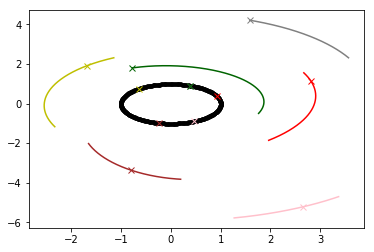

In [115]:
imp.reload(HCU)

# Test what things look like for g_gdot  = (0.4, 0.0)
g_gdot  = (0.4, 0.0)

# Loop over  objects
cnt=0
plt.plot(rawdataDict__['HEC_Earth_'][:,0],rawdataDict__['HEC_Earth_'][:,1],'.',c='k')

refDict__={}
refDict__['ref_vec']={}
refDict__['ref_t']={}
refDict__['ref_ind']={}



for popn,NAME in sample__.items(): 

    # To make things simple, want to choose a reference time and direction that is close to 
    # opposition
    # Think i want to do this by dotting heliocentric vectors and choosing when closest to aligned...
    
    sepnVec=np.array ([np.dot(xyzE/np.linalg.norm(xyzE) ,xyzBody/np.linalg.norm(xyzBody))   for xyzE , xyzBody in zip(rawdataDict__['HEC_Earth_'] , rawdataDict__['helio_posn'][NAME])])
    sepnInd = np.where(sepnVec == np.max(sepnVec))[0][0] # This is the index at which sepn is max
    if sepnInd % 2 ==1: sepnInd -=1                      # Force even: => first detn in tracklet
    
    # Use above index to choose ref time & vector
    ref_vec = detDict__[NAME][sepnInd].heliocentric_unit     # <<-- At directn of the Nth detection
    ref_t   = t_[sepnInd]                                    # <<-- At time    of the Nth detection
    refDict__['ref_vec'][NAME]  =  detDict__[NAME][sepnInd].heliocentric_unit  
    refDict__['ref_t'][NAME]  =  t_[sepnInd]
    refDict__['ref_ind'][NAME]  =  sepnInd



    # create an ARROW for that g,g-dot
    for T in trckDict__[NAME]:
        T.ADD_ARROW(g_gdot,ref_vec,ref_t)
        
    # quick check ...
    print(NAME, sepnInd)
    '''
    print('t_ref , vec_ref = ',ref_t, ref_vec)
    print("times ",trckDict__[NAME][int(sepnInd/2)].times)
    print("t_emit",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].t_emit)
    print("LTTs",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].LTTs_)

    print("theta0",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].theta_[0])
    print("theta1",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].theta_[1])

    print("x",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].x)
    print("y",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].y)

    print("also x?",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].rot_observatory_posn[0][0]*0.4)
    print("also x?",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].rot_observatory_posn[1][0]*0.4)

    print("HEC_Earth_",rawdataDict__['HEC_Earth_'][sepnInd]) 
    print("orig obs posn",detDict__[NAME][sepnInd].observatory_posn)
    print("xyzE=rot_observatory_posn",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].rot_observatory_posn)

    print("xyzE",rawdataDict__['HEC_Earth_'][sepnInd]) 
    
    print("body", rawdataDict__['helio_posn'][NAME][sepnInd])
    print("sepndot", sepnVec[sepnInd])
    print("alphavec",trckDict__[NAME][int(sepnInd/2)].ArrowDict__[g_gdot].alphaVec)

    '''

    col = ['r', 'k', 'b', 'gray', 'y', 'darkgreen', 'pink', 'brown', 'orange']
    if NAME!='Sedna' and NAME!='Chiron':
        plt.plot(rawdataDict__['HEC_Earth_'][:,0][sepnInd],rawdataDict__['HEC_Earth_'][:,1][sepnInd],'x',c=col[cnt])
        plt.plot(rawdataDict__['helio_posn'][NAME][:,0][sepnInd],rawdataDict__['helio_posn'][NAME][:,1][sepnInd],'x',c=col[cnt])
        plt.plot(rawdataDict__['helio_posn'][NAME][:,0],rawdataDict__['helio_posn'][NAME][:,1],'-',c=col[cnt])
    cnt+=1



In [116]:
imp.reload(HCU)

# Test what things look like for g_gdot  = (0.4, 0.0)
g_gdotARR_  = [(0.4, 0.0), (0.288086599319,0.000904622728989)]
for g_gdot in g_gdotARR_:
    for popn,NAME in sample__.items(): 
        # create an ARROW for that g,g-dot
        for T in trckDict__[NAME]:
            #T.ADD_ARROW(g_gdot,ref_vec,ref_t)
            T.ADD_ARROW(g_gdot,refDict__['ref_vec'][NAME] , refDict__['ref_t'][NAME])


/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:196: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha_dot, alpha = np.linalg.lstsq(A, self.x)[0]
/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_dot, beta = np.linalg.lstsq(A, self.y)[0]


# Now lets make some plots
 - At first this will be as part of debugging
 - But then later, for publishable figures

In [117]:
for popn,NAME in sample__.items(): 
    print(popn, NAME)

MBA Crocco
CEN Chiron
TNO Sedna
HIL Hilda
BIG Ceres
HUN Hungaria
JT Achilles
NEO Alinda


# It will be useful to know what the actual values of gamma & gamma-dot are for certain objects 


In [119]:
# Reference time, 
print(ref_t)
# Relative Time Array
t_relD     = np.array(t_)-ref_t # Array length ~730



NAME = 'Crocco'
NAME = 'Alinda'
rHelio=[ np.linalg.norm(item) for item in rawdataDict__['helio_posn'][NAME] ] 
for rH, t in zip(rHelio, t_relD):
    if t > -1 and t < 1:
        print(t, rH, 1/rH)

2458277.5
-0.958333000075072 3.468163152010161 0.28833706955810195
0.0 3.471178466344795 0.28808659931939934
0.04166699992492795 3.471309304133838 0.2880757409917755


# Refining the plot that is required for Fig 1 of the paper 
 - March 18th 2018

## Want to have 
 - (i) Tracklets in topcentric RA/Dec
 - (ii) \theta \dot\theta in transformed heliocentric projected coords 
 - (iii) alpha, beta is helio transf coords

/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:196: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha_dot, alpha = np.linalg.lstsq(A, self.x)[0]
/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_dot, beta = np.linalg.lstsq(A, self.y)[0]


 
 	 NEED TO RETURN TO DOUBLE-CHECK THIS EXTRACTION OF THETA ... 


/Users/matthewjohnpayne/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


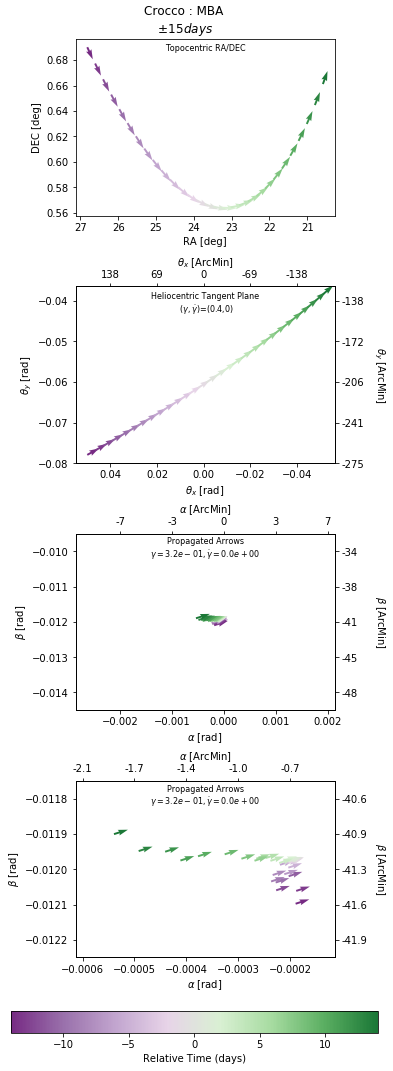

In [126]:
# make the transformations & arrows ...
imp.reload(HCU)

# Test what things look like for g_gdot  = (0.4, 0.0)
# g_gdotARR_  = [(0.3,0.0009)]
#g_gdotARR_  = [(0.4,0.0)]
g_gdotARR_  = [(0.32,0.0)]
for g_gdot in g_gdotARR_:
    for popn,NAME in sample__.items(): 
        # create an ARROW for that g,g-dot
        for T in trckDict__[NAME]:
            #T.ADD_ARROW(g_gdot,ref_vec,ref_t)
            T.ADD_ARROW(g_gdot,refDict__['ref_vec'][NAME] , refDict__['ref_t'][NAME])





###### Make a simple plot of the data 
f, ((ax1, ax3, ax4, ax5)) = plt.subplots(4,1, figsize=(6,15))
font = {'family' : 'normal','size'   : 10}
plt.rc('font', **font)
#cmp=plt.cm.get_cmap('gray')
cmp=brewer2mpl.get_map('PRGn', 'diverging', 8, reverse=False).mpl_colormap

# Lets look at one object, at the relative-time specified above 
NAME = 'Crocco'# 'Alinda' # 'Crocco'
g_gdot = g_gdotARR_[0]
ref_t  = refDict__['ref_t'][NAME]


# Make explicitly clear how the selection of indicees is being done 
dd=15

# Relative times for detections     
t_relD     = np.array(t_)-ref_t                                              # Array length ~730
# Relative times for tracklets 
t_relStart = np.array([T.times[0] for T in trckDict__[NAME]]) -ref_t      # Array length ~365 
t_relEnd   = np.array([T.times[-1] for T in trckDict__[NAME]]) -ref_t     # Array length ~365 
# Coming back to this on May 2nd ... "t_relT" undefinied for some reason
# Don't know why: could it be something related to usinglaptop version? 
# Will try to force a definition for now ... 
t_relT = t_relStart

# These are the (indicees for) tracklet start (and end) -times which are within 15 days of the reference time
indT = [True if t>-dd and t<dd else False for t in t_relT ]
# These are the indicees for the detection times that are within +-15 days 
dt=0.01
indD = [True if t>t_relStart[indT][0]-dt and t<t_relEnd[indT][-1]+dt else False for t in t_relD ]






# Flag to facilitate x-axis reversal 
xREVERSED = True





# Overall Title 
f.suptitle(NAME + " : " + [k for k,v, in sample__.items() if v == NAME][0] + "\n $\pm%d days$" % dd)


# ----------------- (A) ----------------------------------------------------------------
# Plot the original (GeoCentric) RA/DEC
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('DEC [deg]')
ax1.set_title('Topocentric RA/DEC', position=(0.5, 0.9),fontsize=8)
#  - We use [::2] because the detections are arranged in pairs, one hour apart, with a day to the start of the next pair
X = rawdataDict__['F51Obs'][NAME]['RA'][indD][::2]
Y = rawdataDict__['F51Obs'][NAME]['DEC'][indD][::2]
dX = rawdataDict__['F51Obs'][NAME]['RA'][indD][1::2] - X 
dY = rawdataDict__['F51Obs'][NAME]['DEC'][indD][1::2] - Y 
C = t_relD[indD][::2]

'''
print("RA", rawdataDict__['F51Obs'][NAME]['RA'][indD][:3])
print("X",X[:2])
print("dX",dX[:2])
print("DEC", rawdataDict__['F51Obs'][NAME]['DEC'][indD][:3])
print("Y",Y[:2])
print("dY",dY[:2])
'''



# reverse the x-axis ?
if xREVERSED:
    cb1 = ax1.quiver(X,Y, dX, dY, C,cmap=cmp, angles='xy')
    ax1.set_xlim(reversed(ax1.get_xlim()))
else:
    cb1 = ax1.quiver(X,Y, dX, dY, C,cmap=cmp, angles='xy')





# ----------------- (B) ----------------------------------------------------------------    
# Extract the Theta's from the arrows (N.B.: not really depn on g_gdot)
Thetas = []
for T in trckDict__[NAME] :
    for theta in T.ArrowDict__[g_gdot].theta_:
        Thetas.append(theta)
Thetas = np.array( Thetas )[indD]
TX = Thetas[:,0]
TY = Thetas[:,1]
print( " \n \t NEED TO RETURN TO DOUBLE-CHECK THIS EXTRACTION OF THETA ... ")

# Extracting the base point: plot this at the base of the arrow
X = TX[::2]; 
Y = TY[::2]; 
dX = TX[1::2] - X 
dY = TY[1::2] - Y 
C = t_relT[indT]


# reverse the x-axis ?
if xREVERSED:
    cb3 = ax3.quiver(X,Y, dX, dY, C,cmap=cmp, angles='xy')
    ax3.set_xlim(reversed(ax3.get_xlim()))
else:
    cb3 = ax3.quiver(X,Y, dX, dY, C,cmap=cmp, angles='xy')

ax3.set_xlabel('$\\theta_x$ [rad]')
ax3.set_ylabel('$\\theta_y$ [rad]')
ax3.set_title('Heliocentric Tangent Plane\n ($\\gamma,\\dot\\gamma$)=(0.4,0)', position=(0.5, 0.81),fontsize=8)

'''
# Want to force the axes for the theta plot to be equal in scale 
xmid = 0.5*(X[-1]+X[0])
ymid = 0.5*(Y[-1]+Y[0])
sprd = 1.1*np.max( [((X[-1]-xmid)**2)**0.5 , ((Y[-1]-ymid)**2)**0.5] )
ax3.set_xlim( [xmid-sprd, xmid+sprd] )
ax3.set_ylim( [ymid-sprd, ymid+sprd] )
'''

# add a twin axes and set its limits so it matches the first
# apply a function formatter
ax3t = ax3.twinx()
ax3t.set_ylabel('$\\theta_y$ [ArcMin]', rotation=270); ax3t.yaxis.set_label_coords(1.2,0.5)
ax3t.set_ylim(ax3.get_ylim())
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x*(180./np.pi)*60))

ax3t.yaxis.set_major_formatter(formatter)
ax3t = ax3.twiny()
ax3t.set_xlabel('$\\theta_x$ [ArcMin]')
ax3t.set_xlim(ax3.get_xlim())
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x*(180./np.pi)*60))
ax3t.xaxis.set_major_formatter(formatter)



# ----------------- (C) & (D) ----------------------------------------------------------------

g_gdot_lab = [ "%.1e"%item for item in g_gdot]

# Plot the alpha/beta from the arrows
Arrows = np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT]
AX = Arrows[:,0]
AU = Arrows[:,1]
AY = Arrows[:,2]
AV = Arrows[:,3]
C  = t_relT[indT]

# wide limits only on ax4
halfwidth = 0.5*5e-3
xmid = 0.5*(np.min(AX)+np.max(AX))
ymid = 0.5*(np.min(AY)+np.max(AY))
ax4.set_xlim( [xmid-halfwidth, xmid+halfwidth] )
ax4.set_ylim( [ymid-halfwidth, ymid+halfwidth] )

halfwidth = 0.5*5e-4
xmid = 0.5*(np.min(AX)+np.max(AX))
ymid = 0.5*(np.min(AY)+np.max(AY))
ax5.set_xlim( [xmid-halfwidth, xmid+halfwidth] )
ax5.set_ylim( [ymid-halfwidth, ymid+halfwidth] )

for n,ax in enumerate([ax4,ax5]):

    cb = ax.quiver(AX, AY, AU, AV, C,cmap=cmp)#, units='width')
    
    ax.set_xlabel('$\\alpha$ [rad]')
    ax.set_ylabel('$\\beta$ [rad]')
    ax.set_title('Propagated Arrows\n$\\gamma=%s,\\dot\\gamma=%s$'%(g_gdot_lab[0],g_gdot_lab[1]), position=(0.5, 0.82),fontsize=8)

    ax.ticklabel_format(useOffset=False)

    
    # add a twin axes and set its limits so it matches the first
    # apply a function formatter
    axt = ax.twinx()
    axt.set_ylabel('$\\beta$ [ArcMin]',rotation=270 ) ; axt.yaxis.set_label_coords(1.2,0.5)
    axt.set_ylim(ax.get_ylim())
    if n == 0:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x*(180./np.pi)*60))
    else:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x*(180./np.pi)*60))

    axt.yaxis.set_major_formatter(formatter)
    
    axt = ax.twiny()
    axt.set_xlabel('$\\alpha$ [ArcMin]')
    axt.set_xlim(ax.get_xlim())
    if n == 0:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x*(180./np.pi)*60))
    else:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x*(180./np.pi)*60))
    axt.xaxis.set_major_formatter(formatter)
    
    #axt.xaxis.set_major_formatter(FixedOrderFormatter(0))
    #axt.yaxis.set_major_formatter(FixedOrderFormatter(0))
    #axt.yaxis.set_label_coords(0.99,0.5)

    

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag
        

#ax5.xaxis.set_major_formatter(ScalarFormatter(useOffset=True))
#ax5.yaxis.set_major_formatter(ScalarFormatter(useOffset=True))
#ax5.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
#ax5.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

#ax4.xaxis.set_major_formatter(FixedOrderFormatter(-2))
#ax4.yaxis.set_major_formatter(FixedOrderFormatter(-2))
#ax5.xaxis.set_major_formatter(FixedOrderFormatter(-2))
#ax5.yaxis.set_major_formatter(FixedOrderFormatter(-2))


#f.tight_layout()
#f.subplots_adjust(top=0.9)
f.subplots_adjust(left=0.25, bottom=0.1, right=0.85, top=0.95, wspace=0.25, hspace=0.4)

# plot colorbar
cbaxes = f.add_axes([0.1, 0.03, 0.85, 0.02]) 
cb = plt.colorbar(cb1, cax = cbaxes,orientation="horizontal",)  
cb.set_label('Relative Time (days)')

f.savefig('%s.png' % NAME)
f.savefig('%s.pdf' % NAME)

In [ ]:
RA [259.61807 259.60811 259.37195]
X [259.61807 259.37195]
dX [-0.00996 -0.01006]
DEC [-15.43543 -15.43512 -15.42789]
Y [-15.43543 -15.42789]
dY [0.00031 0.00029]

# Let's try to make some different g-gdot combos to illustrate the effect

/pool/pistachio0/Dropbox/ITF/HelioClustering_Utilities.py:195: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/pool/pistachio0/Dropbox/ITF/HelioClustering_Utilities.py:199: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:196: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha_dot, alpha = np.linalg.lstsq(A, self.x)[0]
/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_dot, beta = np.linalg.lstsq(A, self.y)[0]


-0.005605523744020259 0.004986096609923175 -0.014434647460072947 -0.00936635486067535 : -0.0003097135670485419 -0.011900501160374149


/Users/matthewjohnpayne/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


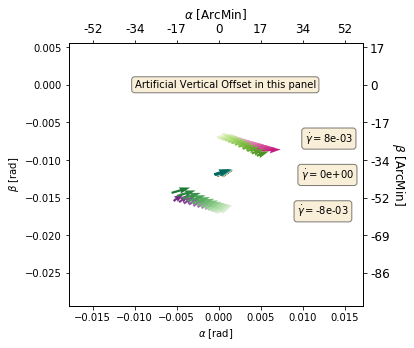

In [121]:
# Make the transformations / arrows 
imp.reload(HCU)

# Set the reference g,gdot
#g_gdotref =  (0.29,0.0009)
g_gdotref =  (0.32,0.0009)
g = g_gdotref[0]
gdotref = g_gdotref[1]

# Now make some g-dot variations
#g_gdotARR_ = [ (g, gdotref*100),(g, gdotref*10),(g, gdotref),(g, 0.0),(g, -gdotref),(g, -10*gdotref),(g, -100*gdotref)]
# g_gdotARR_ = [(g, gdotref),(g, 0.0),(g, -gdotref),(g, -2*gdotref)]
g_gdotARR_ = [(g, -8e-3),(g, 0.0),(g, +8e-3)]

for g_gdot in g_gdotARR_:
    for popn,NAME in sample__.items(): 

        # To make things simple, want to choose a reference time and direction that is close to 
        # opposition
         # --- Already done, can just grab from Dictionaries ...

        # create an ARROW for that g,g-dot
        for T in trckDict__[NAME]:
            T.ADD_ARROW(g_gdot , refDict__['ref_vec'][NAME] , refDict__['ref_t'][NAME])
 



# Make a simple plot of the data 
f, (ax2) = plt.subplots(1,1, figsize=(6,5))
#f = plt.figure()
#ax2 = f.add_axes([0.1, 0.1, 0.68, 0.68])

font = {'family' : 'normal','size'   : 12}
plt.rc('font', **font)


arr = ['PRGn','BrBG', 'PiYG', 'PuOr', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral']
cmp_ =[ brewer2mpl.get_map(arr[i], 'diverging', 8, reverse=False).mpl_colormap  for i,item in enumerate(g_gdotARR_) ]


# Lets look at one object, at the relative-time specified above 
NAME = 'Crocco'
g_gdot = g_gdotARR_[1]
ref_t  = refDict__['ref_t'][NAME]


# Make explicitly clear how the selection of indicees is being done 
dd=15

# Relative times for detections     
t_relD     = np.array(t_)-ref_t                                           # Array length ~730
# Relative times for tracklets 
t_relStart = np.array([T.times[0] for T in trckDict__[NAME]]) -ref_t      # Array length ~365 
t_relEnd   = np.array([T.times[-1] for T in trckDict__[NAME]]) -ref_t     # Array length ~365 
# Coming back to this on May 2nd ... "t_relT" undefinied for some reason
# Don't know why: could it be something related to usinglaptop version? 
# Will try to force a definition for now ... 
t_relT = t_relStart


# These are the (indicees for) tracklet start (and end) -times which are within 15 days of the reference time
### indT = [True if t>-dd and t<dd else False for t in t_relT ]
indT = [True if t>-dd and t<dd else False for t in t_relStart ]

# These are the indicees for the detection times that are within +-15 days 
dt=0.01
indD = [True if t>t_relStart[indT][0]-dt and t<t_relEnd[indT][-1]+dt else False for t in t_relD ]



# Looping over the various different gdots in g_gdotARR_ 
for n,g_gdot in enumerate(g_gdotARR_):

    # Plot the arrows on top of the Thetas ... 
    # ... Can only do this for the first detection in each tracklet 
    Arrows = np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT]
    AX = Arrows[:,0]
    AU = Arrows[:,1]
    AY = Arrows[:,2]
    AV = Arrows[:,3]

    # Arrows
    cb2 = ax2.quiver(AX , AY + (n-1)*0.5e-2, AU, AV, t_relT[indT],cmap=cmp_[n])

 
    # place a text box 
    ax2.text(AX[10]+0.01, AY[10] + (n-1)*0.5e-2, "$\\dot\\gamma=$%.0e" % (g_gdot[1]), fontsize=10, color='black', 
        va='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


ax2.text(-0.01, 0.0, "Artificial Vertical Offset in this panel", fontsize=10, color='black', 
        va='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    
# For publication, want to set the axis scales to be the same (betwen this plot and the one below )
ScaleLen = 3.5e-2 # [radians]
Xmin = np.min( [np.min( np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT][:,0]) for n,g_gdot in enumerate(g_gdotARR_) ] )
Xmax = np.max( [np.max( np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT][:,0]) for n,g_gdot in enumerate(g_gdotARR_) ] )
Ymin = np.min( [np.min( np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT][:,2]) for n,g_gdot in enumerate(g_gdotARR_) ] )
Ymax = np.max( [np.max( np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT][:,2]) for n,g_gdot in enumerate(g_gdotARR_) ] )
Xmid = 0.5*(Xmin+Xmax) 
Ymid = 0.5*(Ymin+Ymax) 
print(Xmin, Xmax, Ymin, Ymax, ":", Xmid, Ymid)    
ax2.set_xlim([Xmid-0.5*ScaleLen , Xmid+0.5*ScaleLen ])
ax2.set_ylim([Ymid-0.5*ScaleLen , Ymid+0.5*ScaleLen ])


    
# Set all of the labels 
ax2.set_xlabel('$\\alpha$ [rad]')
ax2.set_ylabel('$\\beta$ [rad]')

ax2t = ax2.twinx()
ax2t.set_ylabel('$\\beta$ [ArcMin]',rotation=270 ) ; ax2t.yaxis.set_label_coords(1.15,0.5)
ax2t.set_ylim(ax2.get_ylim())
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x*(180./np.pi)*60))
ax2t.yaxis.set_major_formatter(formatter)

ax2t = ax2.twiny()
ax2t.set_xlabel('$\\alpha$ [ArcMin]')
ax2t.set_xlim(ax2.get_xlim())
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x*(180./np.pi)*60))
ax2t.xaxis.set_major_formatter(formatter)







f.tight_layout()

# plot colorbar
#cbaxes = f.add_axes([0.1, 0.05, 0.8, 0.02]) 
#cb = plt.colorbar(cb1, cax = cbaxes,orientation="horizontal",)  
#cb.set_label('Relative Time (days)')

f.savefig('%s_gdot.png' % NAME)

/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:196: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha_dot, alpha = np.linalg.lstsq(A, self.x)[0]
/Users/matthewjohnpayne/Dropbox/ITF/HelioClustering_Utilities.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_dot, beta = np.linalg.lstsq(A, self.y)[0]
/Users/matthewjohnpayne/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_famil

-0.0015515617549890497 0.002961137285270308 -0.012282787707757368 0.016281995052312336 : 0.0007047877651406293 0.0019996036722774837


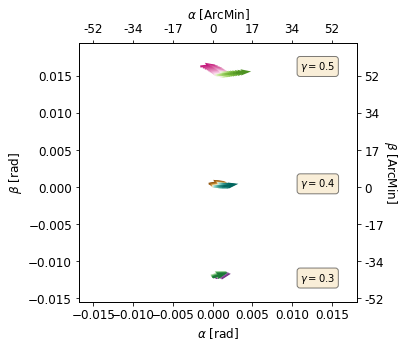

In [122]:
# Make the transformations / arrows 
imp.reload(HCU)

# Set the reference g,gdot
g_gdotref =  (0.32,0.0009)
g = g_gdotref[0]
gdotref = g_gdotref[1]

# Now make some g-dot variations
g_gdotARR_ = [(g, gdotref),(0.4, gdotref),(0.5, gdotref)]

for g_gdot in g_gdotARR_:
    for popn,NAME in sample__.items(): 

        # To make things simple, want to choose a reference time and direction that is close to 
        # opposition
         # --- Already done, can just grab from Dictionaries ...

        # create an ARROW for that g,g-dot
        for T in trckDict__[NAME]:
            T.ADD_ARROW(g_gdot , refDict__['ref_vec'][NAME] , refDict__['ref_t'][NAME])
 



# Make a simple plot of the data 
f, (ax2) = plt.subplots(1,1, figsize=(6,5))
font = {'family' : 'normal','size'   : 12}
plt.rc('font', **font)
f.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)


arr = ['PRGn','BrBG', 'PiYG', 'PuOr', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral']
cmp_ =[ brewer2mpl.get_map(arr[i], 'diverging', 8, reverse=False).mpl_colormap  for i,item in enumerate(g_gdotARR_) ]


# Lets look at one object, at the relative-time specified above 
NAME = 'Crocco'
g_gdot = g_gdotARR_[1]
ref_t  = refDict__['ref_t'][NAME]


# Make explicitly clear how the selection of indicees is being done 
dd=15

# Relative times for detections     
t_relD     = np.array(t_)-ref_t                                              # Array length ~730
# Relative times for tracklets 
t_relStart = np.array([T.times[0] for T in trckDict__[NAME]]) -ref_t      # Array length ~365 
t_relEnd   = np.array([T.times[-1] for T in trckDict__[NAME]]) -ref_t     # Array length ~365 
# Coming back to this on May 2nd ... "t_relT" undefinied for some reason
# Don't know why: could it be something related to usinglaptop version? 
# Will try to force a definition for now ... 
t_relT = t_relStart


# These are the (indicees for) tracklet start (and end) -times which are within 15 days of the reference time
indT = [True if t>-dd and t<dd else False for t in t_relT ]
# These are the indicees for the detection times that are within +-15 days 
dt=0.01
indD = [True if t>t_relStart[indT][0]-dt and t<t_relEnd[indT][-1]+dt else False for t in t_relD ]






# Flag to facilitate x-axis reversal 
xREVERSED = False



# Looping over the various different gdots in g_gdotARR_ 
for n,g_gdot in enumerate(g_gdotARR_):

    # Plot the arrows on top of the Thetas ... 
    # ... Can only do this for the first detection in each tracklet 
    Arrows = np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT]
    AX = Arrows[:,0]
    AU = Arrows[:,1]
    AY = Arrows[:,2]
    AV = Arrows[:,3]

    # Arrows
    cb2 = ax2.quiver(AX, AY, AU, AV, t_relT[indT],cmap=cmp_[n])

    # place a text box 
    if n == 1 or n ==2 :
        ax2.text(0.011, AY[0], "$\\gamma=$%.1f" % (g_gdot[0]), fontsize=10, color='black', 
            va='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        ax2.text(0.011, AY[0], "$\\gamma=$%.1f" % (g_gdot[0]), fontsize=10, color='black', 
            va='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
    
# For publication, want to set the axis scales to be the same (betwen this plot and the one above )
ScaleLen = 3.5e-2 # [radians]
Xmin = np.min( [np.min( np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT][:,0]) for n,g_gdot in enumerate(g_gdotARR_) ] )
Xmax = np.max( [np.max( np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT][:,0]) for n,g_gdot in enumerate(g_gdotARR_) ] )
Ymin = np.min( [np.min( np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT][:,2]) for n,g_gdot in enumerate(g_gdotARR_) ] )
Ymax = np.max( [np.max( np.array( [T.ArrowDict__[g_gdot].alphaVec for T in trckDict__[NAME] ] )[indT][:,2]) for n,g_gdot in enumerate(g_gdotARR_) ] )
Xmid = 0.5*(Xmin+Xmax) 
Ymid = 0.5*(Ymin+Ymax) 
print(Xmin, Xmax, Ymin, Ymax, ":", Xmid, Ymid)    
ax2.set_xlim([Xmid-0.5*ScaleLen , Xmid+0.5*ScaleLen ])
ax2.set_ylim([Ymid-0.5*ScaleLen , Ymid+0.5*ScaleLen ])

    
    
    
# Set all of the labels 
ax2.set_xlabel('$\\alpha$ [rad]')
ax2.set_ylabel('$\\beta$ [rad]')

ax2t = ax2.twinx()
ax2t.set_ylabel('$\\beta$ [ArcMin]',rotation=270 ) ; ax2t.yaxis.set_label_coords(1.15,0.5)
ax2t.set_ylim(ax2.get_ylim())
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x*(180./np.pi)*60))
ax2t.yaxis.set_major_formatter(formatter)

ax2t = ax2.twiny()
ax2t.set_xlabel('$\\alpha$ [ArcMin]')
ax2t.set_xlim(ax2.get_xlim())
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x*(180./np.pi)*60))
ax2t.xaxis.set_major_formatter(formatter)


f.tight_layout()


f.savefig('%s_g.png' % NAME)
f.savefig('%s_g.pdf' % NAME)

In [387]:
for popn,NAME in sample__.items(): 
    print(popn, NAME)

NEO Alinda
HUN Hungaria
HIL Hilda
TNO Sedna
MBA Crocco
CEN Chiron
BIG Ceres
JT Achilles


In [38]:
HP= rawdataDict__['helio_posn']['Alinda']
r = np.array([np.linalg.norm(xyz) for xyz in HP ])

dr = r[1:]-r[:-1]
print( np.min(r), np.max(r), np.mean(r))
print( 1/np.min(r), 1/np.max(r), 1/np.mean(r))

print(r[refDict__['ref_ind'][NAME]])
print(1/r[refDict__['ref_ind'][NAME]])

print(dr[refDict__['ref_ind'][NAME]]) # AU per hour
print(dr[refDict__['ref_ind'][NAME]]*24) # AU per day
print((1/r[refDict__['ref_ind'][NAME]])*dr[refDict__['ref_ind'][NAME]]*24) #  per day





2.635509131752017 3.8355995384584975 3.3777201949605278
0.379433327683151 0.2607154344381566 0.2960576786354223
3.5920437939526018
0.2783930423352726
0.00010908822359256831
0.0026181173662216395
0.0007288656587732534


# Break




-

-



# Now going to attempt to recreate a small section of the results made by Matt H
 - Going to use the data Matt made for plots in Fig 3 & 4 of the paper
 - These data include RA/DEC, Theta, and alpha/beta/etc 
 - These data were made using Holman's main processing notebook, named something like "ITF_2018.iynb"






In [ ]:
import HelioClustering_Utilities as HCU
import imp
imp.reload(HCU)

### The following cells are copied from "HelioClusteringSkyPlots_MJP" to allow me to import the data from Holman quickly

In [42]:
# ------------ Extract Data from Output Dicts in Pickle-File Created by Holman -------------------------- 
def get_dicts(filepath):
    # Get Raw Dicts
    pickledata = pickle.load( open( filepath, "rb" ) )
    dictTopo  = pickledata[0]
    dictTheta = pickledata[1]
    dictArrow = pickledata[2]
    
    # Simplify data dicts 
    dictTopo  = {item[0]:item[1:] for item in dictTopo[281] }
    dictTheta = {item[0]:item[1:] for item in dictTheta[281] }
    dictArrow = {item[0]:item[1:] for item in dictArrow[281][(0.4,0.0)] }
    
    return dictTopo, dictTheta, dictArrow

dictTopo, dictTheta, dictArrow = get_dicts('for_figure3.pickle')
zeroDict = {'dictTopo':dictTopo,'dictTheta':dictTheta , 'dictArrow':dictArrow} 

In [43]:
def get_dicts_multi(filepath):
    # Get Raw Dicts
    pickledata = pickle.load( open( filepath, "rb" ) )
    # Make useful dicts ...
    dictofdicts = {} 
    for k,lst in pickledata[281].items():
        dictofdicts[k] = {item[0]:item[1:] for item in lst }
        
    return dictofdicts

dictofArrowdicts = get_dicts_multi('for_figure4.pickle')
print(dictofArrowdicts.keys())

dict_keys([(0.4, 0.004), (0.4, 0.0), (0.4, 0.002), (0.4, -0.004), (0.4, -0.002)])


In [44]:
print(dictTopo[('K15S08F_007', 57303, '703')])
print(dictTheta[('K15S08F_007', 57303, '703')])
print(dictArrow[('K15S08F_007', 57303, '703')])

(9.081208333333333, 4.345, -4.73005756130442, 9.078875, 4.342555555555555, -4.7150376024656)
(-0.11880731689842633, 0.0069078, -4.73005756130442, -0.11886101285718889, 0.0068845, -4.7150376024656)
(-0.06550003796686624, 0.004805815785782635, -6.364704187224728e-05, -0.000890866391644699, -4.73005756130442)


# Do some processing / calculations to put the data from Holman into a convenient format

In [46]:
# Define the process
def process_SubDicts(Dict, dictArrow):
    dictTopo, dictTheta, IGNOREdictArrow = Dict['dictTopo'], Dict['dictTheta'], Dict['dictArrow']
    
    # Ensure consistency in ordering (just in case)
    listKeys = sorted([k for k,v in dictTopo.items()])

    
    # Sort out the times and IDs
    Dict['t'] = np.array( [dictTheta[k][2] for k in listKeys] )
    Dict['t1']= np.array( [dictTheta[k][5] for k in listKeys] )
    Dict['ID']= np.array( [i for i,k in enumerate(listKeys) ] )
    uniq = list(set([k[0][:7] for k in listKeys ] ))
    D__  = {ID:i for i,ID in enumerate(uniq) }
    Dict['ID']= np.array( [D__[k[0][:7]] for i,k in enumerate(listKeys) ] )
    #print(Dict['ID'][:13])
    
    # Sort out the RA/Dec quantities
    Dict['RA']    = np.array( [dictTopo[k][0] for k in listKeys] )
    Dict['DEC']   = np.array( [dictTopo[k][1] for k in listKeys] )
    Dict['RA1']   = np.array( [dictTopo[k][3] for k in listKeys] )
    Dict['DEC1']  = np.array( [dictTopo[k][4] for k in listKeys] )                
    Dict['dotRA'] =(Dict['RA1']-Dict['RA'])  #/(Dict['t1']-Dict['t'])
    Dict['dotDEC']=(Dict['DEC1']-Dict['DEC'])#/(Dict['t1']-Dict['t'])

    
    # Sort out the Theta quantities 
    Dict['thetax'] = np.array( [dictTheta[k][0] for k in listKeys] )
    Dict['thetay'] = np.array( [dictTheta[k][1] for k in listKeys] )
    Dict['thetax1']= np.array( [dictTheta[k][3] for k in listKeys] )
    Dict['thetay1']= np.array( [dictTheta[k][4] for k in listKeys] )
    Dict['dotthetax']=(Dict['thetax1']-Dict['thetax'])/(Dict['t1']-Dict['t'])
    Dict['dotthetay']=(Dict['thetay1']-Dict['thetay'])/(Dict['t1']-Dict['t'])

    
    # Sort out the Arrow quantities
    # - Expect (alpha, alpha-dot, beta, beta-dot, t)
    Dict['alpha']   = np.array( [dictArrow[k][0] for k in listKeys] )
    Dict['beta']    = np.array( [dictArrow[k][2] for k in listKeys] )
    Dict['dotalpha']= np.array( [dictArrow[k][1] for k in listKeys] )
    Dict['dotbeta'] = np.array( [dictArrow[k][3] for k in listKeys] )

# Run the process
process_SubDicts(zeroDict, dictofArrowdicts[(0.4, 0.0)] )

gdotNeg2 = -0.004
negDict2 = zeroDict.copy()
process_SubDicts(negDict2, dictofArrowdicts[(0.4, gdotNeg2)] )

gdotNeg = -0.002
negDict = zeroDict.copy()
process_SubDicts(negDict, dictofArrowdicts[(0.4, gdotNeg)] )

gdotPos = 0.002
posDict = zeroDict.copy()
process_SubDicts(posDict, dictofArrowdicts[(0.4, gdotPos)] )

gdotPos2 = 0.004
posDict2 = zeroDict.copy()
process_SubDicts(posDict2, dictofArrowdicts[(0.4, gdotPos2)] )

# Let's get comfortable with a small section of the data ...
# ... so that I/we can be confident of the transformations that have to be checked/replicated

In [158]:
# Pick a single tracklet to work with 
print("Topo : ",dictTopo[('K15S08F_007', 57303, '703')])
print("Theta: ",dictTheta[('K15S08F_007', 57303, '703')])
print("Arrow: ",dictofArrowdicts[(0.4, -0.004)][('K15S08F_007', 57303, '703')])
print("Arrow: ",dictofArrowdicts[(0.4, -0.002)][('K15S08F_007', 57303, '703')])
print("Arrow: ",dictofArrowdicts[(0.4, 0.0)][('K15S08F_007', 57303, '703')])
print("Arrow: ",dictofArrowdicts[(0.4, 0.002)][('K15S08F_007', 57303, '703')])
print("Arrow: ",dictofArrowdicts[(0.4, 0.004)][('K15S08F_007', 57303, '703')])

Topo :  (9.081208333333333, 4.345, -4.73005756130442, 9.078875, 4.342555555555555, -4.7150376024656)
Theta:  (-0.11880731689842633, 0.0069078, -4.73005756130442, -0.11886101285718889, 0.0068845, -4.7150376024656)
Arrow:  (-0.06582287637574988, 0.0052127840112038805, -0.00019044912107648036, -0.0009453019844149355, -4.73005756130442)
Arrow:  (-0.06566145717130939, 0.0050092998984929814, -0.00012704808147395513, -0.0009180841880297309, -4.73005756130442)
Arrow:  (-0.06550003796686624, 0.004805815785782635, -6.364704187224728e-05, -0.000890866391644699, -4.73005756130442)
Arrow:  (-0.06533861876243616, 0.004602331673069521, -2.460022698858234e-07, -0.0008636485952595286, -4.73005756130442)
Arrow:  (-0.06517719955799041, 0.004398847560359729, 6.315503733247419e-05, -0.0008364307988743586, -4.73005756130442)


# Some raw data that I believe would have been used by Holman to form the above ...


In [121]:
# (i) >>> grep K15S08F UnnObs_Training_1_line_C.txt | grep 703
obs80 = [
     "     K15S08F  C2015 10 08.27492 00 36 19.49 +04 20 42.0          20.0 Vq~1Xwc703",
     "     K15S08F  C2015 10 08.27992 00 36 19.38 +04 20 38.9          19.5 Vq~1Xwc703",
     "     K15S08F  C2015 10 08.28494 00 36 19.13 +04 20 37.0          20.2 Vq~1Xwc703",
     "     K15S08F  C2015 10 08.28994 00 36 18.93 +04 20 33.2          20.2 Vq~1Xwc703",]
# (ii) >>> grep K15S08F UnnObs_Training_1_line_C.mpc | grep " 703 "
obsConv = [
    "K15S08F_007 2015 10 08.27492   703 20.0  V 2457303.775709    0.9846276    0.1573806    0.0757619     0.967721    0.2288199    0.0992142",
    "K15S08F_007 2015 10 08.27992   703 19.5  V 2457303.780709    0.9846300    0.1573729    0.0757469     0.967698    0.2288972    0.0992472",
    "K15S08F_007 2015 10 08.28494   703 20.2  V 2457303.785729    0.9846335    0.1573551    0.0757377     0.967675    0.2289748    0.0992804",
    "K15S08F_007 2015 10 08.28994   703 20.2  V 2457303.790729    0.9846372    0.1573410    0.0757193     0.967652    0.2290520    0.0993134"
]
# cd ../data" ; grep K15S08F UnnObs_Training_1_line_C_ec_labelled_2457308.5_pm15.0_r2.5.trans | grep " 703 "
obsTran = [
    "K15S08F_007 2015 10 08.27492   703 20.0  V 2457303.775709    0.9846276    0.1745302    0.0069078    0.9677209    0.2494033    0.0000080      0.008677    2.4470661    0.5116247    0.0103866   281",
    "K15S08F_007 2015 10 08.27992   703 19.5  V 2457303.780709    0.9846300    0.1745172    0.0068971    0.9676979    0.2494873    0.0000075      0.008677    2.4470525    0.5116902    0.0103700   281",
    "K15S08F_007 2015 10 08.28494   703 20.2  V 2457303.785729    0.9846335    0.1744972    0.0068958    0.9676748    0.2495717    0.0000071      0.008677    2.4470408    0.5117456    0.0103677   281",
    "K15S08F_007 2015 10 08.28994   703 20.2  V 2457303.790729    0.9846372    0.1744770    0.0068845    0.9676518    0.2496557    0.0000066      0.008677    2.4470295    0.5118004    0.0103503   281",
]

# Let's double-check I understand how to produce obsConv from obs80
 - Next ~5 cells

## We see from doing this that in the "obsConv" list, the vectors are in equatorial coords
  - (i) after the JD, the next three numbers are ObsUnitVector (in Helio EQUATORIAL coords)
  - (ii) the last three numbers are the Observatory.Posn (in Helio EQUATORIAL coords )


## We see from doing this that in the "obsTran" list, the vectors are in ecliptic coords

  - (i) after the JD, the next three numbers are ObsUnitVector (in Helio ECLIPTIC coords)
  - (ii) the next three numbers are the Observatory.Posn (in Helio ECLIPTIC coords )
  - (iii) the next single number (0.008677) is a light travel time 
  - (iv) the next 3 numbers  (2.4470661    0.5116247    0.0103866) are the coords given the assumed 2.5AU distance
  
## I then find that in order to get the values of the arrows sent to me by Holman, I need to assume a lunation_center(-14) 
 - From there, everything seems to be working OK
  

In [123]:
# This returns the topocentric distances and new heliocentric
# position vectors to the target, given the assumed distance
# r and the position vector of the observatory re.
def adjust_position(r, rho_target, re):
    rho_x, rho_y, rho_z = rho_target
    xe, ye, ze = re
    Robs = np.sqrt(xe * xe + ye * ye + ze * ze)
    cos_phi = -(rho_x * xe + rho_y * ye + rho_z * ze) / Robs
    phi = np.arccos(cos_phi)
    sin_phi = np.sin(phi)

    xx2 = r*r - Robs*sin_phi * Robs*sin_phi
    
    if xx2 < 0:
        None, None

    xx = np.sqrt(xx2)
    yy = Robs * cos_phi
    
    rho_p = yy + xx

    # This could be done with numpy arrays
    x_p = xe + rho_p*rho_x
    y_p = ye + rho_p*rho_y
    z_p = ze + rho_p*rho_z
    
    rho_m = yy - xx
    
    # This could be done with numpy arrays    
    x_m = xe + rho_m*rho_x
    y_m = ye + rho_m*rho_y
    z_m = ze + rho_m*rho_z
        
    return (rho_p, (x_p, y_p, z_p)), (rho_m, (x_m, y_m, z_m))


In [135]:
def xyz_to_proj_matrix( r_ref):
    '''This routine returns the 3-D rotation matrix for the 
    given reference vector.
    # mat is a rotation matrix that converts from ecliptic
    # vectors to the projection coordinate system.
    # The projection coordinate system has z outward,
    # x parallel to increasing ecliptic longitude, and
    # y northward, making a right-handed system.
    '''
    x_ref, y_ref, z_ref = r_ref
    r = np.sqrt(x_ref*x_ref + y_ref*y_ref + z_ref*z_ref)
    lon0 = np.arctan2(y_ref, x_ref)
    lat0 = np.arcsin(z_ref/r)
    slon0 = np.sin(lon0)
    clon0 = np.cos(lon0)
    slat0 = np.sin(lat0)
    clat0 = np.cos(lat0)

    mat = np.array([[-slon0, clon0, 0], 
                    [-clon0*slat0, -slon0*slat0, clat0], 
                    [clon0*clat0, slon0*clat0, slat0 ]])

    return mat

In [184]:
def fit_tracklet(t_ref, g, gdot, v, GM=MPC_library.Constants.GMsun):
    # Here's a version that incorporates radial gravitational
    # acceleration
    t_emit = [(obs[0]-obs[1]-t_ref) for obs in v]
    acc_z = -GM*g*g
    fac =[(1.0 + gdot*t + 0.5*g*acc_z*t*t - g*obs[7]) for obs, t in zip(v, t_emit)]
                
    A = np.vstack([t_emit, np.ones(len(t_emit))]).T 
    
    x = [obs[2]*f + obs[5]*g for obs, f in zip(v, fac)]                 
    mx, cx = np.linalg.lstsq(A, x)[0]
            
    y = [obs[3]*f + obs[6]*g for obs, f in zip(v, fac)]                 
    my, cy = np.linalg.lstsq(A, y)[0]
    
    return (cx, mx, cy, my, t_emit[0])

def fit_tracklet_grav(t_ref, g, gdot, v, GM=MPC_library.Constants.GMsun, eps2=1e-16):
    # Here's a more sophisticated version
        
    t_emit = [(obs[0]-obs[1]-t_ref) for obs in v]
        
    # We will approximate g_x(t), g_y(t), and g_z(t)
    # using a Taylor expansion.  
    # The first two terms are zero by design.  
    #
    # Given alpha, beta, gamma,
    # we would have r_0^2 = (alpha^2 + beta^2 + 1)*z_0^2
    # r^2 = (alpha^2 + beta^2 + 1)/gamma^2 ~ 1/gamma^2
    # g_x(t) ~ -0.5*GM*x_0*t^2/r^3 + 1/6*jerk_x*t*t*t
    # g_y(t) ~ -0.5*GM*y_0*t^2/r^3 + 1/6*jerk_y*t*t*t
    # g_z(t) ~ -0.5*GM*z_0*t^2/r^3 + 1/6*jerk_z*t*t*t
    #
    # We do not have alpha and beta initially,
    # but we assert gamma.
    # 
    # We set alpha=beta=0 initially, least squares solve
    # the tracklets and obtain alpha, alpha-dot, beta, 
    # and beta-dot.
    # 
    # Then we use those values to estimate g_x,
    # g_y, and g_z for the next iteration.
    #
    # The process converges when alpha, alpha-dot,
    # beta, beta-dot do not change significantly.
    #
    # We could also do this same process with a 
    # Kepler-stepper or a full n-body integration.
    
    alpha = beta = 0.0
    alpha_dot = beta_dot = 0.0
    cx, cy = 1.0, 1.0
    mx, my = 0.0, 0.0
        
    while(((cx-alpha)*(cx-alpha) + (cy-beta)*(cy-beta))>eps2):
            
        alpha, beta = cx, cy
        alpha_dot, beta_dot = mx, my
            
        r2 = (alpha*alpha + beta*beta + 1.0)/(g*g)
        r3 = r2*np.sqrt(r2)
        r5 = r2*r3

        x0 = alpha/g
        y0 = beta/g
        z0 = 1.0/g
            
        vx0 = alpha_dot/g
        vy0 = beta_dot/g
        vz0 = gdot/g
            
        # An alternative to the Taylor expansion is to
        # to kepler step from
        # x0, y0, z0 and vx0, vy0, vz0 at time 0
        # to those at the times of each observation 
        # in the tracklet.  With that there will be no 
        # issue of convergence.
        # Then simply subtract off the linear motion
        # to give the gravitational perturbation.
            
        rrdot = x0*vx0 + y0*vy0 + z0*vz0
        
        acc_x = -GM*x0/r3
        acc_y = -GM*y0/r3
        acc_z = -GM*z0/r3
            
        jerk_x = -GM/r5*(r2*vx0 - 3.0*rrdot*x0)
        jerk_y = -GM/r5*(r2*vy0 - 3.0*rrdot*y0)
        jerk_z = -GM/r5*(r2*vz0 - 3.0*rrdot*z0)

        fac =[(1.0 + gdot*t + 0.5*g*acc_z*t*t + (1./6.0)*g*jerk_z*t*t*t - g*obs[7]) for obs, t in zip(v, t_emit)]
                
        A = np.vstack([t_emit, np.ones(len(t_emit))]).T 

        x = [obs[2]*f + obs[5]*g - 0.5*g*acc_x*t*t - (1./6.0)*g*jerk_x*t*t*t for obs, f, t in zip(v, fac, t_emit)]                 
        mx, cx = np.linalg.lstsq(A, x)[0]
            
        y = [obs[3]*f + obs[6]*g - 0.5*g*acc_y*t*t - (1./6.0)*g*jerk_y*t*t*t for obs, f, t in zip(v, fac, t_emit)]                 
        my, cy = np.linalg.lstsq(A, y)[0]
        
        return (cx, mx, cy, my, t_emit[0])

In [187]:
imp.reload(HCU)
v = []
for line in obs80:
    # Convert for convenience ... 
    objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = HCU.convertObs80(line)
    #for item in (objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode ):
    #    print(item)

    jd_utc = MPC_library.date2JD(dateObs)
    jd_tdb  = MPC_library.EOP.jdTDB(jd_utc)
    raDeg, decDeg = MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec)
    # make a unit vector, still in equatorial coordinates
    x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
    y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
    z = np.sin(decDeg*np.pi/180.)
    # Then we convert to ecliptic coords ...
    xec, yec, zec = equatorial_to_ecliptic(np.array((x, y, z)))
    #print(x,y,z )
    #print(xec,yec,zec )
    
    if filt.isspace():
        filt = '-'
    if mag.isspace():
        mag = '----'
        
    # Get the position of the observatory 
    # According to the MPC_library code, this is ...
    # ... the heliocentric position of the observatory in equatorial cartesian coordinates.
    xh, yh, zh = Observatories.getObservatoryPosition(obsCode, jd_utc)
    # Then we convert to ecliptic coords ...
    xhec, yhec, zhec = equatorial_to_ecliptic(np.array((xh, yh, zh)))

    #print(xh,yh,zh)
    #print(xhec,yhec,zhec)
    
    
    # The last few columns in the .trans file are apparently "dt         x_cor       y_cor        z_cor       pix"
    # the x_cor       y_cor        z_cor are the light-time corrected positions (of the observation)
    # 
    # this code is from "index_positions" in ITF_mjh_trimmed.ipynb
    # -----------------------------------------------------------------------
    r_target = np.array([xec,yec,zec ])
    print("r_target == xyz_helio-ecliptic")
    print(r_target)
    '''
    
    # Adjust positions
    dt = 0.0
    r_assumed = 2.5
    r_prev = r_assumed # r_func(jd_tdb-dt)
    rho_r_p, rho_r_m = adjust_position(r_prev, r_target, r_obs)
    dt = rho_r_p[0]/MPC_library.Constants.speed_of_light

    # Do light-time iterations.
    i=0
    while(np.abs(r_assumed-r_prev)>1e-8):
        rho_r_p, rho_r_m = adjust_position(r_prev, r_target, r_obs)
        dt = rho_r_p[0]/MPC_library.Constants.speed_of_light
        r_prev = r_assumed #r_func(jd_tdb-dt)
        i += 1
    xp, yp, zp = rho_r_p[1]    
    if line == obs80[0]: print("dt         x_cor       y_cor        z_cor")
    print(dt,  xp, yp, zp)
    # -----------------------------------------------------------------------
    
    '''
    # -----------------------------------------------------------------------
    # --- Get Theta from UV to Target ---
    # specify ref direction 
    ref_vec = np.array(hp.pixelfunc.pix2vec(2**3, 281, nest=True))
    vec = ref_vec/np.linalg.norm(ref_vec)
    # standard rotn matrix to go from ecliptic to projection coords 
    mat = xyz_to_proj_matrix(vec)
    # Rotate to projection coordinates
    theta_x, theta_y, theta_z = np.dot(mat, r_target)
    print("theta_x, theta_y, theta_z")
    print(theta_x, theta_y, theta_z)
    print()
    # -----------------------------------------------------------------------

    # -----------------------------------------------------------------------
    # --- Fit arrows for a given gamma, gamma-dot ---
    
    # Rot posn observatory to proj coords
    r_obs    = np.array([xhec,yhec,zhec])
    xe, ye, ze = np.dot(mat, r_obs)

    # This is the light travel time
    dlt = ze/MPC_library.Constants.speed_of_light

    # Put everything into this tuple ...
    v .append( (jd_tdb, dlt, theta_x, theta_y, theta_z, xe, ye, ze) )
    # -----------------------------------------------------------------------
  


# -----------------------------------------------------------------------
# --- Fit arrows for a given gamma, gamma-dot ---
print("Fitted arrows ... ")
# Define everything else 
# t_ref   = times_[0] - dictTopo[('K15S08F_007', 57303, '703')][2]
t_ref   = 2457308.5 # == lunation_center(-14)
g = 0.4 
gdot = 0.0 

# Call the arrow creation/fitting function 
cx, mx, cy, my, t0 = fit_tracklet(t_ref, g, gdot, v)
print("cx, mx, cy, my")
print("a,adot,b,bdot")
print(cx, mx, cy, my)
print()
# -----------------------------------------------------------------------

     
    
print("# -----------------------------------------------------------------------")
print("\t\t\t Everything looks good ")
print("Critical values (theta's, arrows, etc) can all be made to match to Holman's")
print("# -----------------------------------------------------------------------")


r_target == xyz_helio-ecliptic
[0.98462759 0.17453021 0.00690781]
theta_x, theta_y, theta_z
-0.11880730205875198 0.006907805128941721 0.992893301017698

r_target == xyz_helio-ecliptic
[0.98462997 0.17451719 0.00689712]
theta_x, theta_y, theta_z
-0.11882045585541492 0.006897117305260506 0.9928918012770518

r_target == xyz_helio-ecliptic
[0.98463352 0.17449721 0.00689577]
theta_x, theta_y, theta_z
-0.1188406026662833 0.006895767083635887 0.9928893994570809

r_target == xyz_helio-ecliptic
[0.98463719 0.17447697 0.00688452]
theta_x, theta_y, theta_z
-0.11886103957964422 0.00688452188863832 0.9928870311512841

Fitted arrows ... 
cx, mx, cy, my
a,adot,b,bdot
-0.06550288043058565 0.004805214054377891 -6.121528904736185e-05 -0.0008903525258483633

# -----------------------------------------------------------------------
			 Everything looks good 
Critical values (theta's, arrows, etc) can all be made to match to Holman's
# -----------------------------------------------------------------------

/opt/cfpython/anaconda3.4/lib/python3.4/site-packages/ipykernel/__main__.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/opt/cfpython/anaconda3.4/lib/python3.4/site-packages/ipykernel/__main__.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


# Now I am going to do the same sort of thing again (reporducing Holman's numbers) 
## But I am going to do it using only the machinery I have in place in the Class structures, etc thatr are in place in HCU ...

In [188]:
imp.reload(HCU)

<module 'HelioClustering_Utilities' from '/pool/pistachio0/Dropbox/ITF/HelioClustering_Utilities.py'>

In [190]:
# As per the above, the posn vectors in obsConv are in EQUATORIAL coordinates 
times_           = [float(item.split()[7]) for item in obsConv]
UnitVector_      = [np.array( [float(item.split()[8]),float(item.split()[9]),float(item.split()[10])]) for item in obsConv]
ObservatoryPosn_ = [np.array( [float(item.split()[11]),float(item.split()[12]),float(item.split()[13])]) for item in obsConv]
#ObservatoryPosn_ = [np.array( [float(item.split()[8]),float(item.split()[9]),float(item.split()[10])]) for item in obsConv]
#UnitVector_      = [np.array( [float(item.split()[11]),float(item.split()[12]),float(item.split()[13])]) for item in obsConv]

print(times_)
print(ObservatoryPosn_)
print(UnitVector_) 


[2457303.775709, 2457303.780709, 2457303.785729, 2457303.790729]
[array([0.967721 , 0.2288199, 0.0992142]), array([0.967698 , 0.2288972, 0.0992472]), array([0.967675 , 0.2289748, 0.0992804]), array([0.967652 , 0.229052 , 0.0993134])]
[array([0.9846276, 0.1573806, 0.0757619]), array([0.98463  , 0.1573729, 0.0757469]), array([0.9846335, 0.1573551, 0.0757377]), array([0.9846372, 0.157341 , 0.0757193])]


In [191]:
# Because I am going to  assume inputs in ecliptic coordinates for the vectors in my detectoins/tracklets below
# => Need to convert to ecliptic
EC_UnitVector_      = [HCU.equatorial_to_ecliptic(UV) for UV in UnitVector_]
EC_ObservatoryPosn_ = [HCU.equatorial_to_ecliptic(OP) for OP in ObservatoryPosn_]
print(times_)
print(EC_ObservatoryPosn_)
print(EC_UnitVector_) 


[2457303.775709, 2457303.780709, 2457303.785729, 2457303.790729]
[array([9.67721000e-01, 2.49403296e-01, 7.96353083e-06]), array([9.67698000e-01, 2.49487344e-01, 7.49227948e-06]), array([9.67675000e-01, 2.49571747e-01, 7.08519145e-06]), array([9.67652000e-01, 2.49655703e-01, 6.65371780e-06])]
[array([0.9846276 , 0.17453023, 0.00690781]), array([0.98463   , 0.1745172 , 0.00689711]), array([0.9846335 , 0.17449721, 0.00689575]), array([0.9846372 , 0.17447695, 0.00688447])]


# Now let's look at what I do to form detections, tracklets & arrows ...

In [197]:
imp.reload(HCU)
# ----------------- Detections -------------------------------------------------------
print("\nDetections ...")
detList_ = []
    
# Stuff the detections for each object into a list 
detDict__[NAME] = []
for t, OP, UV in zip(times_, EC_ObservatoryPosn_, EC_UnitVector_):
    # Create a detection
    D = HCU.DETECTION()
    # Add in the data
    D.ADD_TIME(t)
    D.ADD_OBSERVATORYPOSN(OP)
    D.ADD_UNIT(UV)
    # Do utility calculations (at the mo is just heliocentric conversion at assumed 2.5AU) 
    D.ROUGH_HELIO_CONVERSION(2.5)
    # Stick all of the DETECTIONS into a list 
    detList_.append( D )

# ----------------- Tracklets -------------------------------------------------------
print("\nTracklets...")
# Now go through the above list and chop into tracklets based on day 
trckList_ = []
for i,D in enumerate(detList_):
    # Create a new tracklet if appropriate
    if i ==0 or ((int(D.time)- int(trckList_[-1].times[0]))**2)**0.5 > 0.5 :
        trckList_.append(HCU.TRACKLET())

    # Put detections in last tracklet (and calc time list to help with sorting ...)
    trckList_[-1].ADD_DETECTION(D)
    trckList_[-1].GET_TIMES()
print("N_tracklets = ", len(trckList_))
print("D_detections in tracklet = ", len(trckList_[-1].dets_))
print("Unit vectors to detections, assumed to be in ecliptic coords ")
for det in trckList_[0].dets_:
    print(det.time, det.unit)
    
    
# ----------------- Arrows -------------------------------------------------------
print("\nArrows...")
# Test what things look like for g_gdot  = (0.4, 0.0001)
g_gdotARR_  = [(0.4, 0.0)]
ref_t   = lunation_center(-14) # times_[0] + dictTopo[('K15S08F_007', 57303, '703')][2]
print("ref_time = ", ref_t)
# ......= unit vector to 281 in a 768 HEALPIX enumeration () 
# ...... MJP believes that MJH is assuming that the input vec (derived from HP) is in ECLIPTIC coords ...
ref_vec = np.array(hp.pixelfunc.pix2vec(2**3, 281, nest=True))
print("ref_vec (assumed ecliptic coords) = ",ref_vec)

for g_gdot in g_gdotARR_:
    # create an ARROW for that g,g-dot
    for T in trckList_:
        T.ADD_ARROW(g_gdot,ref_vec,ref_t)


print("Theta: ")
for item in trckList_[0].ArrowDict__[g_gdotARR_[0]].theta_:
    print(item)

print("Arrow: ")
print("alpha, alpha-dot, beta, beta-dot, gamma, gamma-dot")
print(trckList_[0].ArrowDict__[g_gdotARR_[0]].alphaVec)

# ----------------- Comparison -------------------------------------------------------
print("# -----------------------------------------------------------------------")
print("\t Comparison between the above calculations using HCU and Holman's numbers (below)\n\t suggests that all is well !")
#print("Topo : ",dictTopo[('K15S08F_007', 57303, '703')])
print("Theta: ")
print("theta_x0, theta_y0, t0, theta_x1, theta_y1, t1")
print(dictTheta[('K15S08F_007', 57303, '703')])
print("Arrow: ")
print("alpha, alpha-dot, beta, beta-dot, t")
print(dictofArrowdicts[g_gdotARR_[0]][('K15S08F_007', 57303, '703')])
print("# -----------------------------------------------------------------------")



Detections ...

Tracklets...
N_tracklets =  1
D_detections in tracklet =  4
Unit vectors to detections, assumed to be in ecliptic coords 
2457303.775709 [0.9846276  0.17453023 0.00690781]
2457303.780709 [0.98463    0.1745172  0.00689711]
2457303.785729 [0.9846335  0.17449721 0.00689575]
2457303.790729 [0.9846372  0.17447695 0.00688447]

Arrows...
ref_time =  2457308.5
ref_vec (assumed ecliptic coords) =  [0.95694034 0.29028468 0.        ]
Theta: 
[-0.11880729  0.00690781  0.99289332]
[-0.11882046  0.00689711  0.99289183]
[-0.1188406   0.00689575  0.99288938]
[-0.11886106  0.00688447  0.99288704]
Arrow: 
alpha, alpha-dot, beta, beta-dot, gamma, gamma-dot
[-6.55139100e-02  4.80287915e-03 -6.28166949e-05 -8.90688387e-04
  4.00000000e-01  0.00000000e+00]
# -----------------------------------------------------------------------
	 Comparison between the above calculations using HCU and Holman's numbers (below)
	 suggests that all is well !
Theta: 
theta_x0, theta_y0, t0, theta_x1, theta_y1,

/pool/pistachio0/Dropbox/ITF/HelioClustering_Utilities.py:195: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/pool/pistachio0/Dropbox/ITF/HelioClustering_Utilities.py:199: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [76]:
# Double-check what healpix
print( hp.pixelfunc.nside2npix(2**3) )
print( hp.pixelfunc.pix2vec(2**3, 281, nest=False) ) 
print( hp.pixelfunc.pix2vec(2**3, 281, nest=True) ) 

768
(-0.18889539204367667, 0.9496412643017708, 0.25)
(0.9569403357322088, 0.29028467725446233, 0.0)


In [175]:
# Returns the jd of new moon, to the nearest half day
def lunation_center(n, tref=2457722.0125, p=29.53055):
    t = tref + p*n
    tp = np.floor(t) + 0.5
    return tp
for n in [-11, -14, -17, -20, -23]:
    print(lunation_center(n))

2457397.5
2457308.5
2457219.5
2457131.5
2457042.5


In [ ]:
2457303.775709